In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from resnet_transfer import *
from resnet_transfer import Resnet_18_Transfer

In [3]:
# Training parameter
num_epochs = 3           
batch_size = 16          
seed = np.random.seed(1234) 

In [4]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: 
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [5]:
class channel_copy(object):
    def __call__(self, img):
        return torch.cat([img, img, img], 0)
    
transform = transforms.Compose([transforms.Resize(512), transforms.ToTensor(), channel_copy()])
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform = transform, 
                                                             p_val = 0.1, p_test = 0.2,
                                                             shuffle = True, show_sample = False, 
                                                             extras = extras)

In [6]:
from loss import *

model = Resnet_18_Transfer(num_classes = 14)
model = model.to(computing_device)

criterion = torch.nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [7]:
total_loss = []
avg_minibatch_loss = []

for epoch in range(num_epochs):
    N = 50
    N_minibatch_loss = 0.0 
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):

        images, labels = images.to(computing_device), labels.to(computing_device)
        optimizer.zero_grad()
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backprop
        optimizer.step() # weight update

        total_loss.append(loss.item())
        N_minibatch_loss += loss
        
        if (minibatch_count + 1) % N == 0:      
            N_minibatch_loss /= N
            print('Epoch: %d ! Average minibatch %d loss: %.3f' %
                (epoch + 1, minibatch_count + 1, N_minibatch_loss))
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0

    print("Finished", epoch + 1, "epochs of training")
print("Training complete after", epoch, "epochs")

Epoch: 1 ! Average minibatch 50 loss: 0.210
Epoch: 1 ! Average minibatch 100 loss: 0.164
Epoch: 1 ! Average minibatch 150 loss: 0.168
Epoch: 1 ! Average minibatch 200 loss: 0.169
Epoch: 1 ! Average minibatch 250 loss: 0.167
Epoch: 1 ! Average minibatch 300 loss: 0.178
Epoch: 1 ! Average minibatch 350 loss: 0.169
Epoch: 1 ! Average minibatch 400 loss: 0.165
Epoch: 1 ! Average minibatch 450 loss: 0.166
Epoch: 1 ! Average minibatch 500 loss: 0.157
Epoch: 1 ! Average minibatch 550 loss: 0.161
Epoch: 1 ! Average minibatch 600 loss: 0.172
Epoch: 1 ! Average minibatch 650 loss: 0.167
Epoch: 1 ! Average minibatch 700 loss: 0.170
Epoch: 1 ! Average minibatch 750 loss: 0.161
Epoch: 1 ! Average minibatch 800 loss: 0.159
Epoch: 1 ! Average minibatch 850 loss: 0.181
Epoch: 1 ! Average minibatch 900 loss: 0.161
Epoch: 1 ! Average minibatch 950 loss: 0.167
Epoch: 1 ! Average minibatch 1000 loss: 0.170
Finished 1 epochs of training
Epoch: 2 ! Average minibatch 50 loss: 0.163
Epoch: 2 ! Average minibat

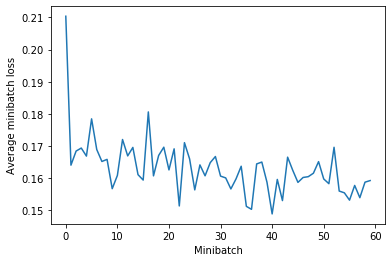

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylabel('Average minibatch loss')
plt.xlabel('Minibatch')
plt.plot(avg_minibatch_loss)
plt.savefig('Plots/fig_3_1.png')
plt.show()

In [11]:
from test import *
from test import Test_Model

In [12]:
labels_all = []
predictions_all = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(computing_device), labels.to(computing_device)
        labels_all.append(labels)
        output = model(images)
        predictions = output > 0.5
        predictions_all.append(predictions)

labels = torch.cat(labels_all, 0)
predctions = torch.cat(predictions_all, 0)
test_res = Test_Model(predctions.float(), labels)
test_res.test_mod()

Classwise statistics: 
Accuracy:  tensor([0.9093, 0.9663, 0.9071, 0.8526, 0.9656, 0.9527, 0.9854, 0.9633, 0.9683,
        0.9874, 0.9799, 0.9760, 0.9695, 0.9970], device='cuda:0',
       dtype=torch.float64)
Precision:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)
Recall:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)
BCR:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', dtype=torch.float64)
Overall statistics: 
Average accuracy:  tensor(0.9557, device='cuda:0', dtype=torch.float64)
Average precision:  tensor(0., device='cuda:0', dtype=torch.float64)
Average recall:  tensor(0., device='cuda:0', dtype=torch.float64)
Average BCR:  tensor(0., device='cuda:0', dtype=torch.float64)
